# Case 3. Pneumonia X-ray image analysis. Group 4 model 1.
**Neural Networks for Machine Learning Applications**<br>
14.12.2024<br>
Ryhmä 4. Jere Karppinen, Jaakko Virtanen, Karim Chaudhri, Miska Nurminen ja Fjoralba Berisha<br>

Hyvinvointi- ja terveysteknologia
Syksy 2024

## 1. Johdanto

Tämän Notebookin tarkoituksena on kehittää syväoppimismalli, joka pystyy luokittelemaan keuhkojen röntgenkuvat kahteen luokkaan: **Normal (normaali)** ja **Pneumonia (keuhkokuume)**.  
Keuhkokuume on yleinen ja mahdollisesti vakava keuhkojen infektio, jossa nopea diagnoosi on kriittinen tehokkaalle hoidolle ja potilaan toipumiselle. Keuhkojen röntgenkuvaus yhdistettynä tekoälyyn tarjoaa lupaavan lähestymistavan tarkempaan ja nopeampaan diagnoosiin.

Tässä projektissa käytetty datasetti sisältää 5,863 röntgenkuvaa, jotka on luokiteltu kahteen kategoriaan (**Normaali/Keuhkokuume**). Datasetti perustuu retrospektiivisiin lasten potilastietoihin, ja kaikki kuvat on arvioitu asiantuntijalääkäreiden toimesta.  
Mallin tavoitteena on hyödyntää syväoppimista, kuten konvoluutiohermoverkkoja (CNN), analysoimaan kuvia tehokkaasti ja tarjoamaan ratkaisu, joka voisi auttaa terveydenhuollon ammattilaisia diagnoosin tukena.

### Notebookin päätavoitteet:
1. **Esikäsitellä ja valmistella datasetti** koneoppimista varten.  
2. **Luoda ja kouluttaa konvoluutiohermoverkko (CNN)** keuhkokuumeen havaitsemiseksi.  
3. **Arvioida mallin suorituskykyä** tarkkuuden, herkkyyden ja spesifisyyden avulla.  
4. **Dokumentoida prosessi ja tulokset** selkeästi jatkokäytöä varten.töä varten.
ttöä varten.


# 2. Setup  
Käytetyt kirjastot:

- **NumPy**: Käytetään matriisien ja taulukoiden käsittelyyn, erityisesti datan esikäsittelyyn ja numeerisiin laskentoihin.
- **Matplotlib**: Visualisointikirjasto, jota käytetään mallin suorituskyvyn ja datan visualisointiin, kuten kaavioiden ja kuvien näyttämiseen.
- **TensorFlow & Keras**: Koko koneoppimis- ja syväoppimisympäristö, joka mahdollistaa mallin rakentamisen, kouluttamisen ja arvioinnin. Keras on TensorFlow'n korkean tason API, jota käytetään mallin luomiseen ja optimointiin.
  - **tensorflow.keras.utils**: Tuodaan `image_dataset_from_directory`-funktio, joka auttaa luomaan datalouhintaa kansioista kuvia.
  - **tensorflow.keras.models**: Mallien luomiseen käytettävä kirjasto, erityisesti `Sequential`-mallin käyttö.
  - **tensorflow.keras.layers**: Eri kerroksia, kuten konvoluutio- ja tiheäkerroksia (Dense), käytetään mallin luomiseen ja syötteen käsittelyyn.
    - **Conv2D**: Käytetään konvoluutiokerroksena kuvadatassa.
    - **MaxPooling2D**: Pooling-kerros, joka vähentää kuvan mittoja ja auttaa laskentatehokkuudessa.
    - **Flatten**: Tasoittaa kerroksista saadun syötteen, jotta sitä voidaan syöttää tiheään kerrokseen.
    - **Dense**: Tiheäkerros, joka yhdistää kaikki edellisen kerroksen neuronit seuraaviin.
    - **Dropout**: Käytetään ylikoulutuksen estämiseen satunnaisesti pudottamalla osan syötekerroksen neuroneista.
    - **Rescaling**: Normalisoi kuvat, jolloin niiden arvoalue saadaan skaalattua välillä 0-1.
    - **RandomFlip, RandomRotation, RandomZoom**: Käytetään datan augmentointiin, eli kuvia käännetään, pyöritetään ja zoomataan satunnaisesti, jotta mallin yleistettävyyttä parannetaan.
    - **BatchNormalization**: Normalisoi kunkin kerroksen syötteen ja auttaa parantamaan mallin koulutusta.
    - **GlobalAveragePooling2D**: Lasketaan kuvasta keskimääräinen arvo ja vähentää tietoa pienemmäksi vektoriksi.
  - **tensorflow.keras.optimizers**: Optimointialgoritmit, kuten Adam, joka optimoi mallin painot.
  - **tensorflow.keras.regularizers**: Käytetään säännöllistämiseen, esimerkiksi L2-regularisointiin.
  - **tensorflow.keras.losses**: Virhefunktiot, kuten `CategoricalCrossentropy`, joita käytetään mallin virheiden arvioimiseen.
  - **tensorflow.keras.metrics**: Mittarit, kuten tarkkuus ja tarkkuus, joita käytetään mallin suorituskyvyn arviointiin.
- **os**: Tarvitaan tiedostojen ja hakemistojen käsittelyyn, esimerkiksi tiedostopoujen määrittämiseen.
ttämiseen.


In [1]:
# Tuodaan tarvittavat kirjastot
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, optimizers, losses, metrics
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

import os

## 3. Datasetti

Chest X-ray Pneumonia -datasetti sisältää **5,863 röntgenkuvaa**, jotka on jaettu kolmeen pääkansioon:
- **Train**: Mallin kouluttamiseen.
- **Test**: Mallin arviointiin.
- **Validation**: Mallin hienosäätöön.

Kuvat on jaoteltu kahteen luokkaan:
- **Normal**: Normaaleja keuhkoja kuvaavat röntgenkuvat.
- **Pneumonia**: Keuhkokuumetta kuvaavat röntgenkuvat, jotka on edelleen jaoteltu bakteeri- ja virusperäisiin keuhkokuumeisiin.

Linkki datasettiin: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [2]:
# Ladataan datat ja asetetaan hakemistopolut
train_folder = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
test_folder = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"
print(os.listdir(train_folder))

['PNEUMONIA', 'NORMAL']


In [3]:
IMG_SIZE = (64, 64)
BATCH_SIZE = 32

# Luodaan koulutusjoukko (train_ds) ja validaatiojoukko (val_ds) ja testijoukko (test_ds)
train_ds = image_dataset_from_directory(
    train_folder,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,  # Kuvan koko (64, 64)
    color_mode="grayscale",  # Mustavalkoiset kuvat
    label_mode="binary",  # Kaksiluokkainen luokittelu
    validation_split=0.2,  # 20% datasta menee validointiin
    subset="training",  # Määritetään koulutusjoukko
    seed=3001,
    shuffle=True
)

val_ds = image_dataset_from_directory(
    train_folder,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode="grayscale",
    label_mode="binary",
    validation_split=0.2,
    subset="validation",  # Määritetään validaatiojoukko
    seed=3001,
    shuffle=True
)

test_ds = image_dataset_from_directory(
    test_folder,  # Testijoukko on erillinen kansio
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode="grayscale",
    label_mode="binary"
)


Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


## 4. Esikäsittely

- Labelit määrittävät, onko röntgenkuvassa pneunomia vai normaali keuhköröntgen. Binäärinen luokitus, jossa 1 = pneunomia ja 0 = normaali.
- 80% dataa käytetään koulutusjoukkoon ja 20% validointijoukkoon.
- Feature: Röntgenkuvat, kooltaan 64x64 pikseliä ja niitä on yksi kanava harmaasävykuvia. Kuvien tietoja eli pikseleitä malli käyttää oppiakseen erottamaan luokat toisistaan.

Kuvien muoto: (32, 64, 64, 1)
Labelien muoto: (32, 1)


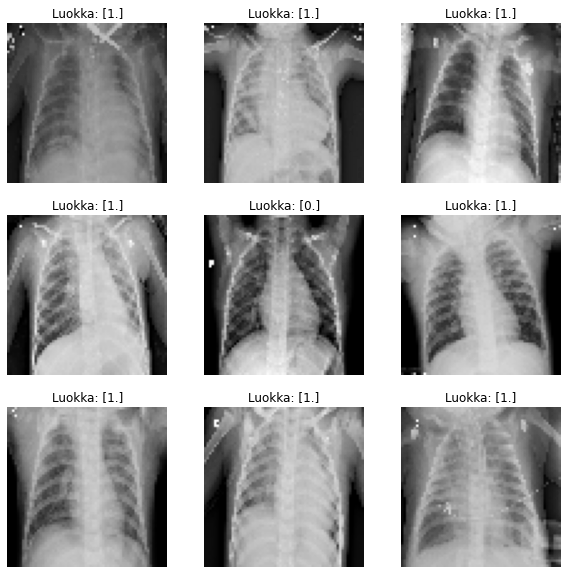

In [4]:
# Näytetään esimerkkejä, että esikäsittely toimii oikein
for images, labels in train_ds.take(1):
    print(f"Kuvien muoto: {images.shape}")
    print(f"Labelien muoto: {labels.shape}")

    # Näytetään ensimmäiset 9 kuvaa
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")  # Kuvan näyttäminen
        plt.title(f"Luokka: {labels[i].numpy()}")  # Näytetään kuvaus (label)
        plt.axis("off")
    plt.show()

## 5. Mallinnus

### Mallin kuvaus

Tämä malli on **konvoluutiohermoverkko (CNN)**, joka on suunniteltu binääriseen kuvien luokitteluun, esimerkiksi normaali- ja poikkeavien lääketieteellisten kuvien tunnistamiseen.  
Malli käsittelee harmaasävykuvia, joiden resoluutio on **64x64** pikseliä, ja normalisoi pikseliarvot välille [0, 1] rescaling-kerroksen avulla.

### Valitut asetukset
- **Tappiofunktio (loss):** Binary Crossentropy  
  - Sopii binääriseen luokitteluun, sillä se mittaa ennusteiden ja todellisten arvojen eroa.  
- **Optimointialgoritmi (optimizer):** Adam  
  - Mukautuva ja tehokas optimointimenetelmä, joka yhdistää momentumin ja oppimisnopeuden säätämisen.  
- **Metrikka (metrics):** Accuracy  
  - Käytetään arvioimaan mallin luokittelutarkkuutta.

### Mallin arkkitehtuurin yhteenveto
1. **Syötekerros:**  
   - Rescaling-kerros normalisoi kuvan pikseliarvot välille [0, 1].

2. **Piirteiden oppimiskerrokset:**  
   - **Ensimmäinen konvoluutiokerros:**  
     - 32 suodatinta, suodinkoko (3,3), ReLU-aktivointi, ja max-pooling.  
   - **Toinen konvoluutiokerros:**  
     - 64 suodatinta, suodinkoko (3,3), ReLU-aktivointi, ja max-pooling.  
   - **Kolmas konvoluutiokerros:**  
     - 128 suodatinta, suodinkoko (3,3), ReLU-aktivointi, ja max-pooling.

3. **Tiheät kerrokset ja ulostulo:**  
   - Flatten-kerros muuntaa 2D-kuvan 1D-vektoriksi.  
   - Dense-kerros (128 yksikköä) käyttää ReLU-aktivointia.  
   - Dropout-kerros (0.5) vähe
   - Toinen Dense-kerros (64) ja Dropout (0.5) kerros.ää yliohjautumisen riskiä.  
   - Ulostulokerros käyttää sigmoid-aktivointia binääriluokitteluun.

### Mallin kääntäminen
Mallin optimointiin, tappiofunktioon ja mittareihin on valittu seuraavat asetukset:  
- **Optimizer:** Adam  
- **Loss:** Binary Crossentropy  
- **Metrics:** Accuracy  
Tämä yhdistelmä varmistaa, että malli oppii tehokkaasti ja pystyy luokittelemaan kuvat tarkasti.

In [5]:
model = Sequential([
    # Rescaling kerros
    Rescaling(1.0/255, input_shape=(64, 64, 1)),

    # Ensimmäinen konvoluutiokerros + Batch Normalization
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Toinen konvoluutiokerros + Batch Normalization
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Kolmas konvoluutiokerros + Batch Normalization
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Global Average Pooling kerros
    GlobalAveragePooling2D(),

    # Täydet yhteydet (Dense) + L2 Regularization
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),

    # Ulostulo-kerros
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 29, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0

In [7]:
# Mallin kääntäminen: määritetään optimointimenetelmä, virhefunktio ja mittarit
model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)

## 6. Koulutus

- Koulutus suoritettiin 20 epookin ajan.
- Koulutuksessa käytetään erän (batch_size) kokoa 32.
- Koulutusdata ja validointidata ovat erikseen määriteltyjä.
- Kokonaiskesto koulutukseen noin 5 minuuttia käyttäen kiihdytintä GPU P100.

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

EPOCHS = 20

# Learning Rate Scheduling
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Mallin koulutus
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/20
131/131 [==============================] - 29s 160ms/step - loss: 1.4583 - accuracy: 0.9032 - precision: 0.9412 - recall: 0.9272 - val_loss: 1.3049 - val_accuracy: 0.7526 - val_precision: 0.7526 - val_recall: 1.0000
Epoch 2/20
131/131 [==============================] - 14s 99ms/step - loss: 0.5015 - accuracy: 0.9427 - precision: 0.9660 - recall: 0.9563 - val_loss: 1.6276 - val_accuracy: 0.7526 - val_precision: 0.7526 - val_recall: 1.0000
Epoch 3/20
131/131 [==============================] - 14s 100ms/step - loss: 0.2619 - accuracy: 0.9617 - precision: 0.9735 - recall: 0.9748 - val_loss: 1.8613 - val_accuracy: 0.7526 - val_precision: 0.7526 - val_recall: 1.0000
Epoch 4/20
131/131 [==============================] - 13s 98ms/step - loss: 0.1921 - accuracy: 0.9626 - precision: 0.9760 - recall: 0.9735 - val_loss: 1.1269 - val_accuracy: 0.7526 - val_precision: 0.7526 - val_recall: 1.0000
Epoch 5/20
131/131 [==============================] - 14s 101ms/step - loss: 0.1592 - accuracy

## 7. Suorituskyky ja arviointi

### Mallin koulutustulokset (Epookit 1-20)

#### Yleiskatsaus:
- **Tarkkuus (Accuracy):** Malli parani jatkuvasti koulutuksen aikana, alkaen 90,32 % epookista 1 ja saavuttaen lähes täydelliset tulokset 99,88 %:n tarkkuudella epookissa 19.
- **Tarkkuus (Precision):** Malli osoitti erittäin korkean tarkkuuden koko koulutuksen ajan, joka nousi 94,12 %:sta 99,87 %:iin.
- **Palautus (Recall):** Palautus oli korkea koko koulutuksen ajan, alkaen 92,72 % ja nousten 99,97 %:iin.
- **Validointitulos:** Validointitarkkuus nousi koulutuksen aikana ja saavutti korkeimman tasonsa 96,64 %:ssa epookissa 17. Validointihäviö vaihteli ja oli suurimmillaan epookissa 11, mikä voi viitata ylikoulutukseen.
- **Häviö (Loss):** Häviö väheni jatkuvasti, alkaen 1,4583:sta epookista 1 ja saavuttaen 0,0595:n tason epookissa 19. Validointihäviö oli kuitenkin epävakaa, erityisesti epookissa 11.

#### Keskeiset havainnot:
- Malli parani nopeasti alkuvuosina ja pysyi korkealla tarkkuudella, tarkkuudella ja palautuksella.
- Validointitarkkuudessa havaittiin heilahtelua, erityisesti epookissa 11, mikä voi viitata ylikoulutukseen.
- Epookeissa 18-20 malli saavutti lähes täydelliset tulokset (99,88 % tarkkuus) ja korkeat tarkkuuden ja palautuksen arvot.
- Ylikoulutuksen estämiseksi voidaan harkita lisätekniikoita, kuten regularisointia, aikaisempaa pysäytystä tai ristivarmistusta.

#### Yhteenveto:
- **Koulutustarkkuus:** 99,88 %
- **Koulutustarkkuus (Precision):** 99,87 %
- **Koulutuspalautus (Recall):** 99,97 %
- **Validointitarkkuus (Highest):** 96,64 %
- **Validointihäviö (Highest):** 2,2774 (Epookki 11)
- **Koulutushäviö:** 0,0595
.n ja recallin).kuvien tunnistamisessa.
ktuskyvyn.

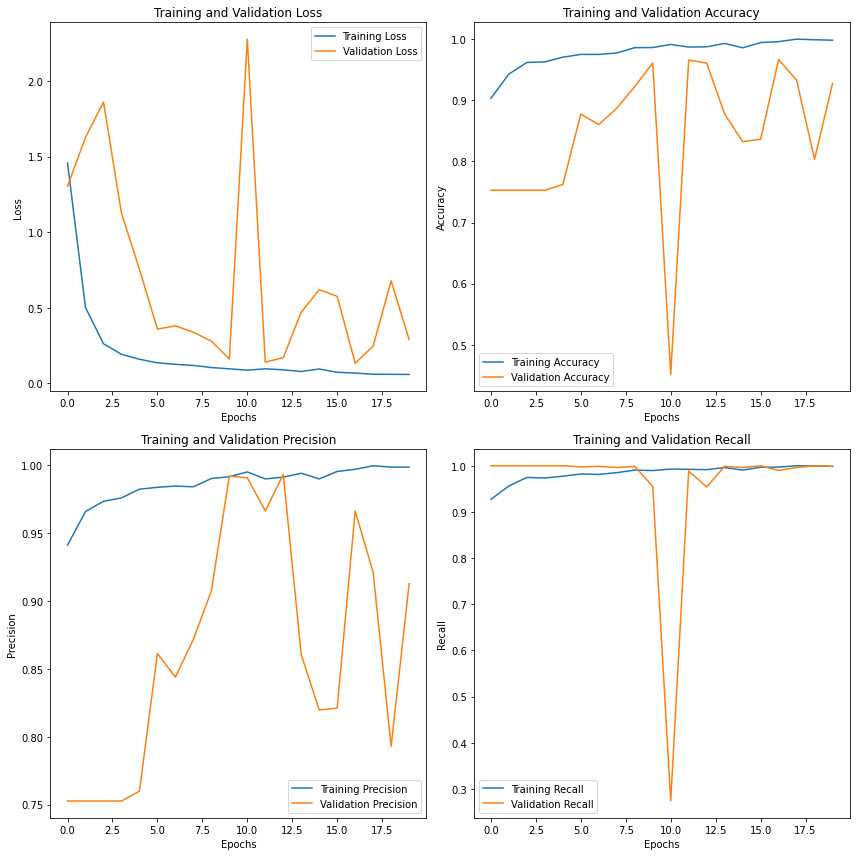

In [9]:
# Plot training and validation loss, accuracy, precision and recall
plt.figure(figsize=(12, 12))

# Loss plot
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Precision plot
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Training and Validation Precision')
plt.legend()

# Recall plot
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Training and Validation Recall')
plt.legend()

plt.tight_layout()
plt.show()
